# SEO Content Quality & Duplicate Detector



In [25]:
# Imports & Config
import os, re, json, pickle, time, ast
import numpy as np
import pandas as pd

from pathlib import Path
from bs4 import BeautifulSoup
import requests

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns


from textstat import flesch_reading_ease, sentence_count
import pprint

BASE = Path("../").resolve()
DATA_DIR = BASE / "data"
MODELS_DIR = BASE / "models"
DATA_DIR.mkdir(exist_ok=True, parents=True)
MODELS_DIR.mkdir(exist_ok=True, parents=True)

print("Using:", DATA_DIR)


Using: C:\Users\Dell\OneDrive\Desktop\LW\seo-content-detector\data


## 1) Load Dataset and set seed


In [26]:

raw_path = DATA_DIR / "data.csv"
df_raw = pd.read_csv(raw_path)
df_raw.head()



,url,html_content
0,https://www.cm-alliance.com/cybersecurity-blog,"<!doctype html><!--[if lt IE 7]> <html class=""..."
1,https://www.varonis.com/blog/cybersecurity-tips,"<!doctype html><html lang=""en""><head>\n <me..."
2,https://www.cisecurity.org/insights/blog/11-cy...,<!DOCTYPE html><html data-unhead-vue-server-re...
3,https://www.cisa.gov/topics/cybersecurity-best...,"\n\n<!DOCTYPE html>\n<html lang=""en"" dir=""ltr""..."
4,https://www.qnbtrust.bank/Resources/Learning-C...,NaN


## 2) Parse HTML

In [27]:
SEMANTIC_TAGS = ["main", "article", "section"]
def extract_title_and_text(html: str):
    if not isinstance(html, str) or not html.strip():
        return "", ""
    soup = BeautifulSoup(html, "html.parser")
    for tag in soup(["script", "style", "nav", "aside", "footer", "noscript"]):
        tag.decompose()
    title = soup.title.string.strip() if (soup.title and soup.title.string) else ""
    for name in SEMANTIC_TAGS:
        node = soup.find(name)
        if node:
            text = " ".join(p.get_text(" ", strip=True) for p in node.find_all(["p","li"]))    
            if len(text.split()) > 50:
                return title, text
    text = " ".join(p.get_text(" ", strip=True) for p in soup.find_all("p"))
    return title, text

def clean_text(t: str) -> str:
    t = (t or "").lower()
    t = re.sub(r"\s+", " ", t).strip()
    return t

def scrape_url(url: str, timeout=15):
    try:
        headers = {"User-Agent": "Mozilla/5.0 (Assignment Demo)"}
        r = requests.get(url, headers=headers, timeout=timeout)
        r.raise_for_status()
        return r.text
    except Exception:
        return ""

rows = []
need_scrape = "html_content" not in df_raw.columns
for i, row in df_raw.iterrows():
    url = row.get("url", "")
    html = row.get("html_content", "") if not need_scrape else scrape_url(url)
    if need_scrape:
        time.sleep(1.2)  # be polite
    title, body = extract_title_and_text(html)
    body_clean = clean_text(body)
    wc = len(re.findall(r"\w+", body_clean))
    rows.append({"url": url, "title": title, "body_text": body_clean, "word_count": wc})

df_parsed = pd.DataFrame(rows)
parsed_path = DATA_DIR / "extracted_content.csv"
df_parsed.to_csv(parsed_path, index=False)
df_parsed.head()


,url,title,body_text,word_count
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,,0
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,contents cybersecurity is gaining more importa...,1617
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,cybersecurity is inextricably tied to the tech...,1004
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,cyberspace is particularly difficult to secure...,509
4,https://www.qnbtrust.bank/Resources/Learning-C...,,,0


## 3) Feature Engineering

In [28]:
def basic_features(text: str) -> dict:
    txt = text or ""
    words = re.findall(r"\w+", txt)
    wc = len(words)
    try:
        sc = sentence_count(txt)
    except Exception:
        sc = max(1, txt.count(".") + txt.count("!") + txt.count("?"))
    try:
        fre = float(flesch_reading_ease(txt))
    except Exception:
        fre = 0.0
    return {"word_count": wc, "sentence_count": sc, "flesch_reading_ease": fre}

# Compute features
feats = []
for _, r in df_parsed.iterrows():
    f = basic_features(r["body_text"])
    f.update({"url": r["url"], "title": r["title"], "body_text": r["body_text"]})
    feats.append(f)

df_feats = pd.DataFrame(feats)

# TF-IDF for keywords and duplicates
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)
X_tfidf = tfidf.fit_transform(df_feats["body_text"].fillna(""))

def top_keywords_from_tfidf_row(i, top_k=5):
    row = X_tfidf.getrow(i)
    if row.nnz == 0:
        return []
    indices = row.indices
    data = row.data
    top_idx = data.argsort()[::-1][:top_k]
    vocab = tfidf.get_feature_names_out()
    return [vocab[indices[j]] for j in top_idx]

df_feats["top_keywords"] = ["|".join(top_keywords_from_tfidf_row(i)) for i in range(X_tfidf.shape[0])]

features_path = DATA_DIR / "features.csv"
df_feats.to_csv(features_path, index=False)
df_feats.head()


,word_count,sentence_count,flesch_reading_ease,url,title,body_text,top_keywords
0,0,0,0.000000,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,,
1,1617,80,38.920251,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,contents cybersecurity is gaining more importa...,to|the|and|in|your
2,1004,60,53.569778,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,cybersecurity is inextricably tied to the tech...,you|your|to|the|and
3,509,23,9.653990,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,cyberspace is particularly difficult to secure...,and|cybersecurity|cyber|the|of
4,0,0,0.000000,https://www.qnbtrust.bank/Resources/Learning-C...,,,


## 4) Duplicate Detection (+ Thin Content)

In [29]:
# Cosine similarity on TF-IDF
S = cosine_similarity(X_tfidf)
threshold = 0.80

dupes = []
n = S.shape[0]
for i in range(n):
    for j in range(i+1, n):
        if S[i, j] >= threshold:
            dupes.append({"url1": df_feats.loc[i, "url"], "url2": df_feats.loc[j, "url"], "similarity": float(S[i, j])})

df_dupes = pd.DataFrame(dupes)
dupes_path = DATA_DIR / "duplicates.csv"
df_dupes.to_csv(dupes_path, index=False)

# Thin content
df_feats["is_thin"] = df_feats["word_count"] < 500

print("Summary:")
print("Total pages:", len(df_feats))
print("Duplicate pairs:", len(df_dupes))
print("Thin content pages:", int(df_feats["is_thin"].sum()))
df_dupes.head()


Summary:
Total pages: 81
Duplicate pairs: 2
Thin content pages: 36


,url1,url2,similarity
0,https://en.wikipedia.org/wiki/SD-WAN,https://www.fortinet.com/resources/cyberglossa...,0.827993
1,https://copyblogger.com/content-marketing/,https://www.twilio.com/en-us/blog/insights/con...,0.813378


## 5) Quality Labels & Model

Model Performance (RandomForest, tuned):
              precision    recall  f1-score   support

         Low       0.93      0.93      0.93        15
      Medium       0.86      0.86      0.86         7
        High       1.00      1.00      1.00        15

    accuracy                           0.95        37
   macro avg       0.93      0.93      0.93        37
weighted avg       0.95      0.95      0.95        37

Baseline Acc: 0.28
Model Acc: 0.9459459459459459

Confusion Matrix (rows = true, columns = predicted):
Labels order: [Low, Medium, High]
[[14  1  0]
 [ 1  6  0]
 [ 0  0 15]]


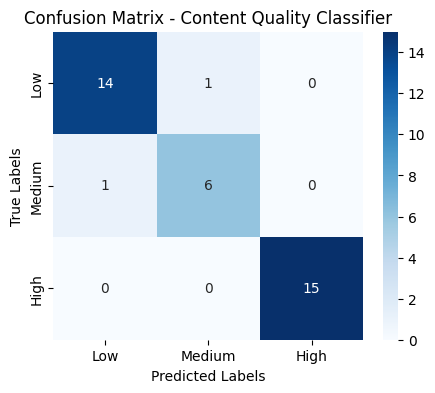

word_count: 0.046
sentence_count: 0.074
flesch_reading_ease: 0.100
avg_sentence_length: 0.015
keyword_density: 0.008
complex_word_ratio: 0.047
punctuation_density: 0.023
avg_keyword_density: 0.008
content_depth_score: 0.105


In [34]:
# ----- Derived features (no chained-assignment warnings)
df_feats["avg_sentence_length"] = (df_feats["word_count"] / df_feats["sentence_count"].replace(0, np.nan)).fillna(0)

df_feats["keyword_density"] = df_feats["body_text"].apply(
    lambda t: len(re.findall(r"seo|google|content|keyword", str(t))) / max(len(str(t).split()), 1)
)
df_feats["complex_word_ratio"] = df_feats["body_text"].apply(
    lambda t: len([w for w in str(t).split() if len(w) > 8]) / max(len(str(t).split()), 1)
)
df_feats["punctuation_density"] = df_feats["body_text"].apply(
    lambda t: len(re.findall(r"[.,!?;:]", str(t))) / max(len(str(t).split()), 1)
)
df_feats["keyword_count"] = df_feats["body_text"].apply(
    lambda t: len(re.findall(r"seo|content|google|keyword", str(t)))
)
df_feats["avg_keyword_density"] = (df_feats["keyword_count"] / df_feats["word_count"].replace(0, np.nan)).fillna(0)
df_feats["content_depth_score"] = ((df_feats["word_count"] * df_feats["flesch_reading_ease"]) / 1000).fillna(0)

# ----- Labels (same rules you had)
def rule_label(word_count: int, readability: float) -> str:
    if word_count > 1500 and 50 <= readability <= 70:
        return "High"
    elif word_count < 500 or readability < 30:
        return "Low"
    else:
        return "Medium"

df_feats["label"] = [rule_label(w, r) for w, r in zip(df_feats["word_count"], df_feats["flesch_reading_ease"])]
label_map = {"Low": 0, "Medium": 1, "High": 2}
y = df_feats["label"].map(label_map).values

# ----- Upsample "High" class to balance
df_high = df_feats[df_feats["label"] == "High"]
if len(df_high) > 0:
    df_feats = pd.concat([df_feats, df_high.sample(10, replace=True,random_state=42)], ignore_index=True)
    y = df_feats["label"].map(label_map).values  # refresh y after upsampling

# ----- Build features for the model
# IMPORTANT: Use a *separate* TF-IDF for the model so we don't overwrite the earlier one used for duplicates.

tfidf_m = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)
X_tfidf_m = tfidf_m.fit_transform(df_feats["body_text"].fillna(""))


svd = TruncatedSVD(n_components=80, random_state=42)
X_tfidf_reduced_m = svd.fit_transform(X_tfidf_m)

X_num = df_feats[[
    "word_count","sentence_count","flesch_reading_ease",
    "avg_sentence_length","keyword_density",
    "complex_word_ratio","punctuation_density",
    "avg_keyword_density","content_depth_score"
]].fillna(0).values


scaler = StandardScaler()
X_scaled = np.hstack([scaler.fit_transform(X_num), X_tfidf_reduced_m])

# ----- RandomForest (class-weighted to help "High")
clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=14,
    min_samples_split=3,
    min_samples_leaf=1,
    class_weight={0:1, 1:1, 2:4},  # emphasize High
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Train/test split and evaluation
X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)

print("Model Performance (RandomForest, tuned):")
print(classification_report(y_te, y_pred, target_names=["Low","Medium","High"]))
print("Baseline Acc:", 0.28)
print("Model Acc:", accuracy_score(y_te, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_te, y_pred, labels=[0, 1, 2])

print("\nConfusion Matrix (rows = true, columns = predicted):")
print("Labels order: [Low, Medium, High]")
print(cm)


# Compute matrix
cm = confusion_matrix(y_te, y_pred, labels=[0, 1, 2])
labels = ["Low", "Medium", "High"]

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Content Quality Classifier")
plt.show()




# Save model
with open(MODELS_DIR / "quality_model.pkl", "wb") as f:
    pickle.dump(clf, f)

# Feature importances (top numeric features only; trees don't expose names for TF-IDF SVD parts directly)
importances = clf.feature_importances_
feature_names = [
    "word_count","sentence_count","flesch_reading_ease","avg_sentence_length",
    "keyword_density","complex_word_ratio","punctuation_density",
    "avg_keyword_density","content_depth_score"
]
for name, imp in zip(feature_names, importances[:len(feature_names)]):
    print(f"{name}: {imp:.3f}")


## 6) Real-Time Analysis Function

In [31]:
# Uses the fitted TF-IDF (X_tfidf) and corpus to find near duplicates, plus the trained classifier.
def analyze_url(url: str, top_k=5, sim_threshold=0.80):
    headers = {"User-Agent": "Mozilla/5.0 (Assignment Demo)"}
    try:
        r = requests.get(url, headers=headers, timeout=15)
        r.raise_for_status()
        html = r.text
    except Exception as e:
        return {"url": url, "error": str(e)}
    # Parse
    soup = BeautifulSoup(html, "html.parser")
    for tag in soup(["script","style","nav","aside","footer","noscript"]):
        tag.decompose()
    title = soup.title.string.strip() if (soup.title and soup.title.string) else ""
    text = " ".join(p.get_text(" ", strip=True) for p in soup.find_all("p"))
    txt = re.sub(r"\s+", " ", text.lower()).strip()
    # Features
    words = re.findall(r"\w+", txt)
    wc = len(words)
    try:
        sc = sentence_count(txt)
    except Exception:
        sc = max(1, txt.count(".")+txt.count("!")+txt.count("?"))
    try:
        fre = float(flesch_reading_ease(txt))
    except Exception:
        fre = 0.0
    # Duplicates vs corpus
    xq = tfidf.transform([txt])
    sims = cosine_similarity(xq, X_tfidf).ravel()
    top_i = np.argsort(sims)[::-1][:top_k]
    similar_to = []
    for i in top_i:
        if sims[i] >= sim_threshold:
            similar_to.append({"url": df_feats.loc[i, "url"], "similarity": float(sims[i])})
    # Predict
    try:
        with open(MODELS_DIR/"quality_model.pkl", "rb") as f:
            clf_loaded = pickle.load(f)
        pred = clf_loaded.predict([[wc, sc, fre]])[0]
        label = {0:"Low",1:"Medium",2:"High"}[int(pred)]
    except Exception:
        # Fallback to rule label
        label = "High" if (wc > 1500 and 50 <= fre <= 70) else ("Low" if (wc < 500 or fre < 30) else "Medium")
    return {
        "url": url, "title": title,
        "word_count": wc, "readability": fre,
        "quality_label": label,
        "is_thin": wc < 500,
        "similar_to": similar_to
    }


res = analyze_url("https://anvil.works/learn/examples/simple-website-guide")

pprint.pp(res)



{'url': 'https://anvil.works/learn/examples/simple-website-guide',
 'title': 'Simple Website',
 'word_count': 318,
 'readability': 63.00392783311409,
 'quality_label': 'Low',
 'is_thin': True,
 'similar_to': []}
